<a href="https://colab.research.google.com/github/ciaopeps/ULMFit_Sentiment/blob/master/ULMFit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


## Universal Language Model Fine Tuning (ULMFiT) is a transfer learning algorithm which allows you to fit a language model and a classifier. It is based on a pretrained model (WIKITEXT 103) and then fine tuned using the specific corpus of the problem. It is based on an LSTM network architecture with droputs applied to every layer.

## Import relevant packages

In [ ]:
import pandas as pd
import numpy as np
from fastai.text import *
from sklearn.model_selection import train_test_split as tts
import regex as re


## DATASET

In this section i am loading the dataset and performing some exploratory analysis. The dataset represents tweets commenting on 6 US airline perfomance with their sentiment. 

In [ ]:
tweets = pd.read_csv('/content/gdrive/My Drive/ULMFit Airlines/Tweets.csv') #loadind the dataset
df = tweets[['airline_sentiment','text']] #extract tweets and sentitment

df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


I am now encoding the categorical variable *airline_sentiment* into integers where:
- positive = 2
- neutral = 1
- negative = 0

I am also renaming the column to *labels*

In [ ]:
from sklearn.preprocessing import LabelEncoder
# creating instance of labelencoder
labelencoder = LabelEncoder()
# Assigning numerical values and updating the value
df['airline_sentiment'] = labelencoder.fit_transform(df.airline_sentiment)
df = df.rename(columns={'airline_sentiment':'labels'})

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Graphical representation of airline sentiment absolute and relative counts. It cleary stands out that the dataset is higly imbalanced with more the 60% of the tweets belonging to the negative class. For this reason I will fit two models, one with raw data and the other with resampled data.

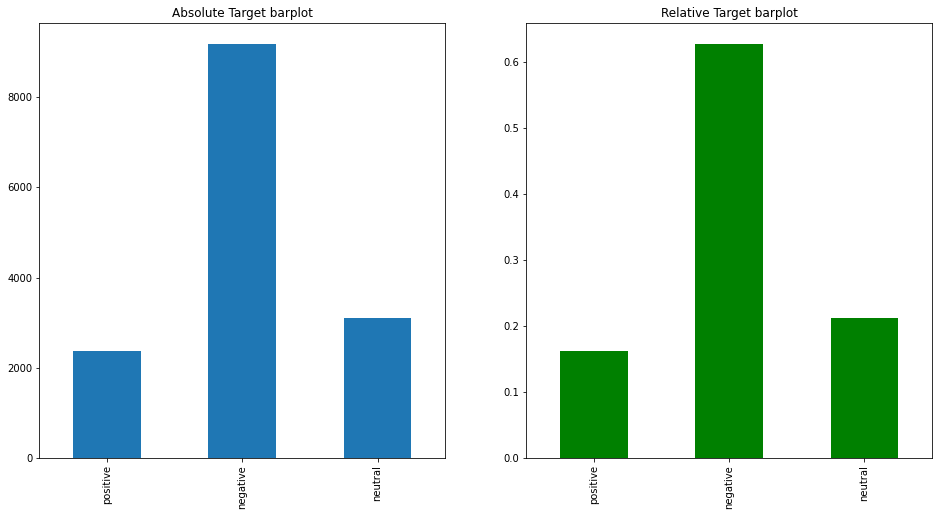

In [ ]:
positive = (df['labels'] == 2).sum()
neutral = (df['labels'] == 1).sum()
negative = (df['labels'] == 0).sum()

y_bars = pd.Series([positive, negative,neutral], index=['positive', 'negative','neutral'])

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
y_bars.plot(kind='bar', title='Absolute Target barplot', ax=ax[0])
(y_bars / y_bars.sum()).plot(kind='bar', title='Relative Target barplot', ax=ax[1], color='green')
# fig.suptitle(target)
plt.show()

## DATA CLEANING AND PREPROCESSING

In this section I am going to clean and preprocess the dataset so that it can be used to fit the model.

In [ ]:
#importing relavant libraries for prepocessing
import re
import nltk
import time
from spacy.lang.en.stop_words import STOP_WORDS


Since the nature of the texts are tweets I am going to perform expansion of contractions. This allows the model to pick up the content of the tweet intended by the user. 

In [ ]:
# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
  def replace(match):
    return contractions_dict[match.group(0)]
  return contractions_re.sub(replace, text)

# Expanding Contractions in the reviews
df['text']=df['text'].apply(lambda x:expand_contractions(x))


Using the regex library I am removing tags (@) unrecognized characters and web urls. Finally I put the next in low case. 

In [ ]:
#remove words which are starts with @ symbols
df['text'] = df['text'].map(lambda x:re.sub('@\w*','',str(x)))
#remove special characters except [a-zA-Z]
df['text'] = df['text'].map(lambda x:re.sub('[^a-zA-Z]',' ',str(x)))
#remove link starts with https
df['text'] = df['text'].map(lambda x:re.sub('http.*','',str(x)))
#low case text
df['text'] = df['text'].map(lambda x:str(x).lower())


Using spacy STOP_WORDS set I am cleaning the texts and updating the columns df['text']

In [ ]:

corpus = []
none=df['text'].map(lambda x:corpus.append(' '.join([word for word in str(x).strip().split() if not word in STOP_WORDS]))) 
df['text'] = corpus

## LANGUAGE MODEL

Split the dataset in train and test using sklearn train test split

In [ ]:
from sklearn.model_selection import train_test_split as tts
df_train, df_test = tts(df, stratify = df['labels'], test_size = 0.2)

Create the data for the language model. The language model tuned on top of the pretrained WIKITEXT103 and fined tuned using the dataset. `TextLMDataBunch` generates DataBunch used by the model. In this step the labels are ignored as the model learns the sequence of the words. It will be able to predict the next n words given a starting word. It automatically performs tokenization. I will explained in the appendix how fastai.text tokenization works. 

In [ ]:
data_lm = TextLMDataBunch.from_df(train_df = df_train, valid_df = df_test, path = "")
data_lm.show_batch()

idx,text
0,trying xxbos booked flight guys reconsidering decision reading tweet xxbos tourist wonder super tides tide century french u k coasts xxbos aww thanks aa dfw gma understand btw airline i m able trv love guys xxbos flight leaving xxunk board update website asap xxbos dang pandora look like pushed likely xxbos okay thanks update told airport today xxbos hours phone waiting find luggage shameonyou xxbos paid paypal online charged system
1,managed figure trying diff confirmation s booked annoying xxunk available xxbos hour delay single staff member ticket desk admirals club sweet xxunk xxbos thanks xxbos finally chicago hours late flight food voucher wait hr good bye xxbos xxunk flight couple weeks ago frustrated policies amp xxunk xxbos far xxbos wanted sign airline credit card absurd change fee switch flight think twice xxbos seats assigned inappropriate child age aa knew age
2,xxbos happy finally southwestairlines boarding pass passbook makes life easier xxbos hold hours pick xxunk xxrep 5 e xxbos priority xxunk xxbos stop cancelled flighting flights provide real help customers xxunk xxbos sent plane jetblue clue xxbos sm xxrep 4 o xxunk flight attendants xxunk xxbos applied job xxunk follow love job xxunk xxbos gary serving fll airport counter true blue makes feel home jetblue flight xxunk xxbos nope currently
3,tried hung twice speaking hold minutes resolution xxbos sent feedback thank xxbos thanks follow glad bag xxbos lie xxbos xxunk vacation sxm got delayed day xxunk service earliest fll gt sxm flight trying hep xxbos received flights united truly breaks guitars xxunk xxunk xxbos willing benefit doubt misunderstood went xxbos hell terrible gate agents hour wait gate xxbos school trip including sleep airport different standby flights good xxbos airways hits
4,nassau news live xxbos rude gate agent bwi tonight gate b hr delay flight think little training order xxbos cancelled flightlations delay causing miss connecting flight night home thanks pathetic xxbos weeks refund ticket totally unacceptable fix blast social media tv xxbos running tweeter word fleek xxbos checking consistently called multiple times loyal aa customer disappointed xxbos know information found people account reservation rr trip xxbos expect spend hard earn


### Now we define the language model and set the learning rates. 

`language_model_learner()` imports the pretrained model and assigns it to variable learner where:
- data_lm is the data bunch created above
-AWD_LSTM model architecture
- drop_multi is the dropout rate in the model 

In [ ]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

Fine tuning a model consists of gradually update the weights of the pretrained model according to the data we input.
`lr_find()` runs a few epochs on the model to estimate the minimum learning rate we use in the gradient descent. It also plots  the loss in fuction of learning rate.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-02
Min loss divided by 10: 9.12E-02


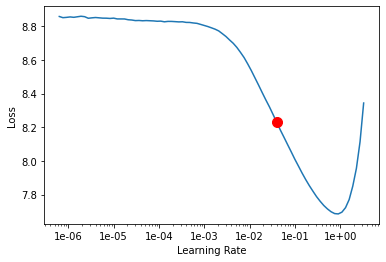

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr #assign to variable the suggested min gradient

Gradually I continue to fine tune the model. I fit the model for a few cycles by running 2 epochs and then unfreezing and running more epochs to complete the fine tuning.  

In [ ]:
learn.fit_one_cycle(2, min_grad_lr)



epoch,train_loss,valid_loss,accuracy,time
0,7.064650,5.964035,0.151711,00:08
1,6.289535,5.846117,0.157626,00:08


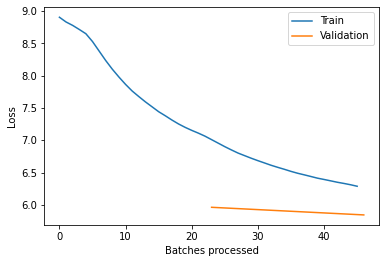

In [ ]:
learn.recorder.plot_losses()



Unfreezing all the layers and fit the language model.

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(4, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,5.520026,5.799984,0.163839,00:10
1,5.393930,5.763777,0.164993,00:10
2,5.225480,5.817681,0.165662,00:10
3,5.072079,5.838803,0.164509,00:10


## CLASSIFIER

Using the language model trained on the new dataset I am now fitting the classifier. In a similir process as above I am loading the DataBunch. This time `TextClasDataBunch()` does not ignore the class labels so that the models learns the sentiment of the tweets. 

In [ ]:
data_clas = TextClasDataBunch.from_df(train_df = df_train, valid_df = df_test, path = "", vocab=data_lm.train_ds.vocab, bs=32)

In [ ]:
class_ = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.74E-01
Min loss divided by 10: 2.09E-02


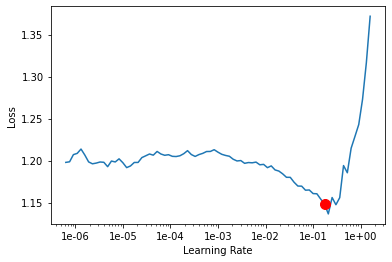

In [ ]:
class_.lr_find()
class_.recorder.plot(suggestion=True)
min_grad_lr = class_.recorder.min_grad_lr

Once again, I am using the gradul unfreezing technique.  Starting by training the last few layers and then gradually go backwards and unfreeze and train layers before. To do so I use the `learn.freeze_to()` function. Where the argument is an integer number that indicates the number of layers I want to unfreeze. 
I start by unfreezing the first two layers and train.

In [ ]:
class_.fit_one_cycle(2, min_grad_lr)


epoch,train_loss,valid_loss,accuracy,time
0,0.995934,0.975023,0.626708,00:10
1,0.945963,0.929181,0.628074,00:10


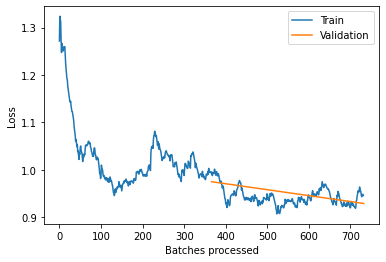

In [ ]:
class_.recorder.plot_losses()


`slice(start,end)` allows you to set a learning rate intervall. The first group's learning rate is start, the last is end, and the remaining are evenly geometrically spaced.

In [ ]:
class_.freeze_to(-2)
class_.fit_one_cycle(4, slice(5e-3, 2e-3), moms=(0.8,0.7))


epoch,train_loss,valid_loss,accuracy,time
0,0.926858,0.881666,0.625683,00:11
1,0.898756,0.980788,0.643101,00:11
2,0.840226,0.854053,0.652322,00:11
3,0.851775,0.836166,0.654372,00:11


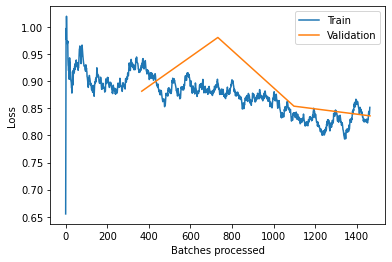

In [ ]:
class_.recorder.plot_losses()


In [ ]:
class_.unfreeze()
class_.fit_one_cycle(4, slice(2e-3/100, 2e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.789618,0.787928,0.679303,00:24
1,0.762253,0.764639,0.670424,00:24
2,0.700568,0.716193,0.713456,00:24
3,0.662087,0.685705,0.718238,00:24


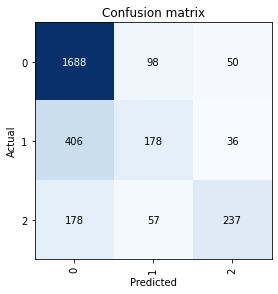

In [ ]:
preds,y,losses = class_.get_preds(with_loss=True)
interp = ClassificationInterpretation(class_, preds, y, losses)
interp.plot_confusion_matrix()

In [ ]:
accuracy(preds, y)

tensor(0.7182)

Given the imbalanced nature of the dataset the confusion matrix correctly predicts negative class tweets. To avoid this I now try to resample the dataset to an even number of tweets for each class and see if accuracy is improved. I use the `df.sample()` function to randomly resample the data. I then concatenate the resample dataset for each class

In [ ]:
#extract dataset for the same class
df0 = df[df['labels'] == 0]
df1 = df[df['labels'] == 1]
df2 = df[df['labels'] == 2]

In [ ]:
df0.shape,df1.shape,df2.shape

((9178, 2), (3099, 2), (2363, 2))

In [ ]:
# randomly resample each class specific dataframe 
df0 = df0.sample(n=2300)
df1 = df1.sample(n=2300)
df2 = df2.sample(n=2300)
df0.shape,df1.shape,df2.shape

((2300, 2), (2300, 2), (2300, 2))

In [ ]:
#concatenate to generate the final resample dataset
frames = [df0, df1, df2]
sampled_df = pd.concat(frames).reset_index().drop(columns='index')
sampled_df.shape

(6900, 2)

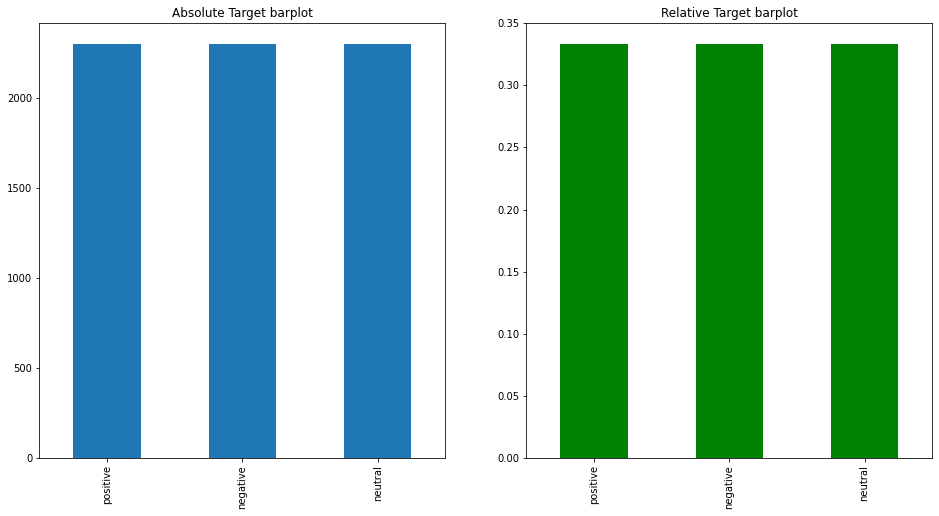

In [ ]:
#plot the resampled dataset
positive = (sampled_df['labels'] == 2).sum()
neutral = (sampled_df['labels'] == 1).sum()
negative = (sampled_df['labels'] == 0).sum()

y_bars = pd.Series([positive, negative,neutral], index=['positive', 'negative','neutral'])

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
y_bars.plot(kind='bar', title='Absolute Target barplot', ax=ax[0])
(y_bars / y_bars.sum()).plot(kind='bar', title='Relative Target barplot', ax=ax[1], color='green')
# fig.suptitle(target)
plt.show()

#I now run the same step as above on the new dataset.

## LANGUAGE MODEL RESAMPLED

Split the dataset in train and test using sklearn train test split

In [ ]:
from sklearn.model_selection import train_test_split as tts
sampled_train, sampled_test = tts(sampled_df, stratify = sampled_df['labels'], test_size = 0.2)

Create the data for the language model. The language model tuned on top of the pretrained WIKITEXT103 and fined tuned using the dataset. `TextLMDataBunch` generates DataBunch used by the model. In this step the labels are ignored as the model learns the sequency of the words. It will be able to predicts the next n words given a starting word. It automatically performs tokenization. I will explained in the appendix how fastai.text tokenization works. 

In [ ]:
data_lm = TextLMDataBunch.from_df(train_df = sampled_train, valid_df = sampled_test, path = "")
data_lm.show_batch()

idx,text
0,believe paid money xxbos helpful flight cancelled flightled reflight booking problems aa email cell notifications xxbos reminder ll tweeting join xxbos airport snow removal method good work folks cessna xxbos welcome xxbos xxunk vegas bad i d xxunk destinationdragons xxbos worst customer service calling month book flight poorcustomerservice xxunk xxbos dm u add xxbos use help getting bags iad headed xxunk going xxunk xxbos stuck tarmac mins phl waiting load
1,xxunk flights xxunk xxbos thanks having hang tampa airport forever today awesome experience xxbos confirmation number new reservation xxunk m y traveling year old email xxunk xxunk com xxbos control weather control customer service luggage hours amp speak human xxbos despite bag making newark good informative email tracking updates help xxbos july zero xxunk date system causes problems like xxbos funny story website broken missing xxunk xxunk checkin process dislike
2,looking forward xxunk onboard xxbos rocks xxunk xxbos going miss airways provided great service let xxbos look beauty dc united airlines hope like beauty xxbos dividend miles credit card amp book flight bag free xxbos want shout thank pilots staff feb flight newark boston pm super helpful xxbos lady b abq great service cancelled flightlations xxbos xxunk usair happy night lt xxbos good xxbos anymore xxbos cost day vacation got
3,fll buf xxbos offered complimentary drink switching seats stewardess asked xxunk amp said xxunk xxunk xxunk xxbos frontier xxbos customer service rude xxunk calls idea going xxunk heavily phone unbelievable xxbos yes awful weather appears home xxbos time today phl nice work xxunk xxbos love passbook update day released finally thank xxbos think priority member wonder treat xxunk know rewards card cancelled flightling immediately xxbos cancelled flightled flights fort lauderdale
4,u plane destination instead xxbos help upgrade xxunk select ca nt xxunk right area know guys good xxbos adds austin dallas love field route xxbos flight moved booked said arrive says xxbos great airline xxbos got flight thanks xxbos tried lovely customer service thank xxbos friend stuck bus runway xxunk small kids customer service explanation kids crying awful service xxbos mention fact paid extra fly jetblue thinking reliable xxbos sent


### Now we define the language model and set the learning rates. 

`language_model_learner()` imports the pretrained model and assigns it to variable learner where:
- data_lm is the data bunch created above
-AWD_LSTM model architecture
- drop_multi is the dropout rate in the model 

In [ ]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

Fine tuning a model consists of gradually update the weights of the pretrained model according to the data we input.
`lr_find()` runs a few epochs on the model to estimate the minimum learning rate we use in the gradient descent. It also plots  the loss in fuction of learning rate.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-02
Min loss divided by 10: 9.12E-02


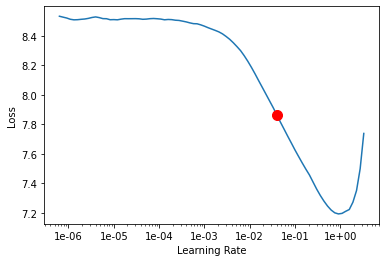

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr #assign to variable the suggested min gradient

Gradually I continue to fine tune the modelx. I fit the model for a few cycles by running 2 epochs and then unfreezing and running more epochs to complete the fine tuning.  

In [ ]:
learn.fit_one_cycle(2, min_grad_lr)



epoch,train_loss,valid_loss,accuracy,time
0,7.325967,5.838331,0.143006,00:03
1,6.481793,5.685578,0.165551,00:03


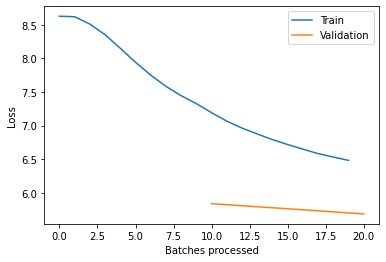

In [ ]:
learn.recorder.plot_losses()



Unfreezing all the layers and fit the language model.

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(4, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,5.532931,5.654544,0.162500,00:04
1,5.433630,5.553893,0.171429,00:04
2,5.301911,5.525669,0.184747,00:04
3,5.194525,5.532135,0.182589,00:04


## CLASSIFIER RESAMPLED

Using the language model trained on the new dataset I am now fitting the classifier. In a similir process as above I am loading the DataBunch. This time `TextClasDataBunch()` does not ignore the class labels so that the models learns the sentiment of the tweets. 

In [ ]:
data_clas = TextClasDataBunch.from_df(train_df = sampled_train, valid_df = sampled_test, path = "", vocab=data_lm.train_ds.vocab, bs=32)

In [ ]:
class_ = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.37E-01
Min loss divided by 10: 1.58E-07


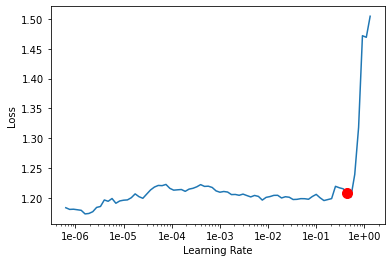

In [ ]:
class_.lr_find()
class_.recorder.plot(suggestion=True)
min_grad_lr = class_.recorder.min_grad_lr

Once again, I am using the gradul unfreezing technique.  Starting by training the last few layers and then gradually go backwards and unfreeze and train layers before. To do so I use the `learn.freeze_to()` function. Where the argument is an integer number that indicates the number of layers I want to unfreeze. 
I start by unfreezing the first two layers and train.

In [ ]:
class_.fit_one_cycle(2, min_grad_lr)


epoch,train_loss,valid_loss,accuracy,time
0,1.448099,1.205236,0.334058,00:05
1,1.135330,1.105226,0.321014,00:04


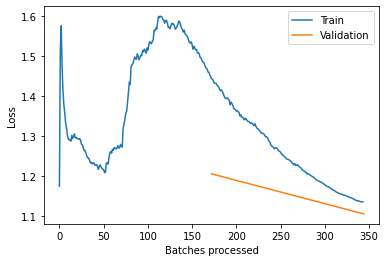

In [ ]:
class_.recorder.plot_losses()


`slice(start,end)` allows you to set a learning rate intervall. The first group's learning rate is start, the last is end, and the remaining are evenly geometrically spaced.

In [ ]:
class_.freeze_to(-2)
class_.fit_one_cycle(4, slice(5e-3, 2e-3), moms=(0.8,0.7))


epoch,train_loss,valid_loss,accuracy,time
0,1.095083,61.352722,0.317391,00:05
1,1.074188,1.109203,0.334058,00:05
2,1.055995,1.038685,0.485507,00:06
3,1.050753,1.018635,0.497826,00:05


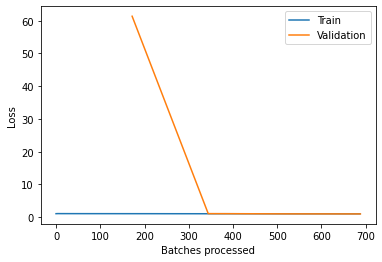

In [ ]:
class_.recorder.plot_losses()


In [ ]:
class_.unfreeze()
class_.fit_one_cycle(4, slice(2e-3/100, 2e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.985060,0.895461,0.594928,00:12
1,0.910533,0.875236,0.589130,00:11
2,0.820865,0.788173,0.652899,00:12
3,0.784386,0.784789,0.650725,00:11


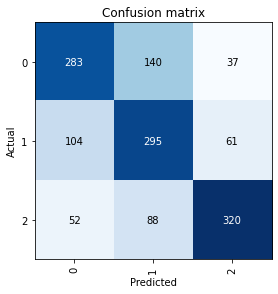

In [ ]:
preds,y,losses = class_.get_preds(with_loss=True)
interp = ClassificationInterpretation(class_, preds, y, losses)
interp.plot_confusion_matrix()

In [ ]:
accuracy(preds, y)

tensor(0.6507)

The accuracy for the resampled data did not improve from the raw dataset. Although it is not crystal clear the reason why some tweets have been mislabeled a better approach for the future is not focus more on the feature engeneering. Moreover, text tweets is always a tricky problem as people are not concerned with grammar and English words.

# APPENDIX

## In this appendix I will explain how the fast ai tokenization works.

We want to transform a list of strings (text) into a list of token. Similarly to a list of words but with some common rules. Fastai uses Spacy a common library for data preprocessing in NLP. It then adds a beginning of tweet token in order to recognize when a new text starts. It is useful to know when a new text is starting as in a language model we concatenate all the text together and it is important to know when texts finish because it might be the case that we need to forget some of the context at the end of the text.
FastAI tokenizer  has some interesting features. For example it adds tokens in front of cap words in order to maintain the magnitude of the meaning of the word. Usually all caps means shouting and might have a different impact on the sentiment. Get the semantic impact of shouted (CAP) version of the token. Tokens are all lower cased but additional token before cap words indicates their semantic meaning. At the same time if a word is followed by '!!!!!!!!' it has a different semantic impact and this is also taken in consideration in the fastai tokenization.

In [ ]:
train_text = df_train['text']
token_train =  Tokenizer().process_all(train_text)

NUMERICALISING the token means mapping each unique token to an integer:
- make a list of all the words that appear (vocabulary)
- and replace the words with the index into the list 

usually in NLP problems we dont need every single unique token in the vocabulary. for example tokens with a very low frequency might be typos or not conveying any kind of information to the language model. 

In [ ]:
freq = Counter(p for o in token_train for p in o)
freq

In [ ]:
max_voc = 10000
min_freq = 0 #appear at least twice

In [ ]:
# int to string = list of unique tokens present in the vocabolary
i2s = [o for o,c in freq.most_common(max_voc)if c > min_freq] #sorts by frequency  and discard words wich dont appear more then twice
i2s.insert(0,'_unk_') # unknown 
i2s.insert(1,'_pad_') # padding

In [ ]:
#  string to int creates the vocabulary, it doesnt cover everything bc truncated to max_voc number of words

s2i = collections.defaultdict(lambda: 0, {v:k for k,v in enumerate(i2s)})

In [ ]:
train_lm = np.array([[s2i[o] for o in p] for p in token_train])
vs = len(i2s)

# CONCLUSION

The above project applies a semi-supervised ULMFiT model to Twitter US Airlines Sentiment. It is based on the fast.ai ULMFiT algorithm which consists of an LSTM network with dropout rates at each layer. Before training the classifier I build a language model. This is done using the transfer learning technique as my base model is a pretrained model on the WIKITEXT103 database. Subsequently I update the model using the data of this project. Before feeding the text to the algorithm I clean and preprocess the text. Given the imbalance of the dataset I also train a second model by randomly sampling from the original dataset so that I obtain a balance dataset. However, this doesn't improve the accuracy of the classifier. This could be due because of the syntax of the tweets which doesn't follow common English grammar rules. Further works should focus on a better cleaning preprocess that takes into consideration the such issues.